### SELF-SUPERVISED SEISMIC DENOISING: PART THREE 
# Coherent Noise Suppression with Blind-Trace Networks
### _Authors: [Claire Birnie](https://cebirnie92.github.io/)_ _and_ _[Sixiu Liu](https://swagroup.kaust.edu.sa/people/detail/sixiu-liu-(%E5%88%98%E6%80%9D%E7%A7%80))_ , _KAUST_

------------------


**But noise is seldom, if ever, random...**

This is the third tutorial in our self-supervised seismic denoising tutorial series. Here we move away from the assumption of i.i.d. imposed by the original blind-spot procedure, and instead, we tackle coherent noise using blind-masks. 

The tutorial notebooks were originally designed to supplement the course slides. However, it should still be easy to follow provided you have read the reference paper and understood the key concepts.

## Tutorial Objectives
On completion of this tutorial, you will have 
- loaded a synthetic survey containing multiple shot gathers and added trace-wise noise
- use helper functions to cut the shot gather into training patches
- write a function for selecting active pixels and corrupting their full trace
- use helper functions to load a UNet
- import your previously written train and evaluate functions
- write the training procedure
- apply the trained network to the seismic image with a new realisation of tracewise noise

## Prior Requisites:
This tutorial relies on the training and evaluate functions from tutorial 1. These have been copied into ssdn_functions.py. If you have not completed the earlier tutorials, it is advised to such that you can get a full understanding of the workflow. 

## Reference Paper:
Liu, S., Birnie, C. and Alkhalifah, T., 2023. Trace-wise coherent noise suppression via a self-supervised blind-trace deep-learning scheme. Geophysics, 88(6), pp.V459-V472.

[[Paper Link]](https://doi.org/10.1190/geo2022-0371.1)

## Key Concepts Recap
#### _N2V: Random Noise Suppression_
In this series of tutorials, we implement the Noise2Void methodology of [Krull et al., [2019]](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf) for self-supervised denoising using blind-spot networks. This approach involves a pre-processing step that identifies a set of 'active' pixels, substituting their original noisy values with those of neighboring pixels. This processed data becomes the input to the neural network with the original noisy image being the network's target. However, unlike in most NN applications, the loss is not computed across the full predicted image, but only at the active pixel locations. Assuming the noise is i.i.d., the network is unable to predict the noise component of the active pixels' original values, thereby learning to reconstruct only the signal component. This results in a denoised image.

#### _StructN2V: Coherent Noise Suppression_
N2V requires noise to be independent, however this is a rare occurrence. [Broaddus et al., [2020]](https://ieeexplore.ieee.org/document/9098336) proposed StructN2V to extend the blind-spot methodology to coherent noise suppression. To do so, first, the raw data is evaluated to determine the relationship between noise elements across pixels. This analysis is used to build a noise mask that is designed to hide any pixels which exhibit coherency between their noise elements and the noise of the central pixel. Once the mask is designed, active pixels are selected (like in the original N2V methodology) however now not only is the central pixel's value changed, as is all pixels that fall within the noise mask. As the mask covers neighbouring pixels, the  values used for corruption are typically drawn from a predefined distribution.  Corrupting all pixels within the mask region ensures the input to the network has no useable information for predicting the noise component of the central pixels. As before, the loss is only computed at the active pixels locations. In theory, the network learns to use pixels out with the masked area to recreate the central pixel's value.


***

In [1]:
# Import necessary basic packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm 
import os

# Import necessary torch packages
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

# Import our pre-made functions which will keep the notebook concise
# These functions are independent to the blindspot application however important for the data handling and 
# network creation/initialisation
from unet import UNet
import tutorial_utils as tu
import plotting_utils as pu


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Some general plotting parameters so we don't need to keep adding them later on
cmap='RdBu'
vmin = -0.25
vmax = 0.25

# For reproducibility purposes we set random, numpy and torch seeds
tu.set_seed(42) 

# Set paths
data_dir = './data'
networks_dir = './trained_networks'

***

# Step One - Data loading
In this example we are going to use a 10 synthetic common shot gathers extracted from the Volve synthetic modelling of [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.6572286.svg)](https://doi.org/10.5281/zenodo.6572286)
. The data is available  from [this One Drive](https://drive.google.com/drive/folders/1AovokXsyo6VYxfzLZ2gpvVHLadh5wuN1?usp=sharing).

(10, 256, 180)


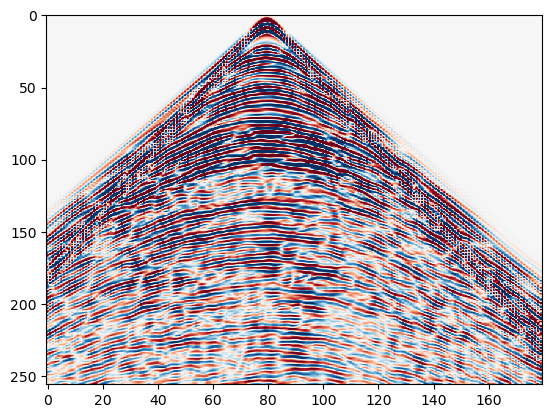

In [3]:
d = np.load(os.path.join(data_dir,'volvesynth_vz.npy'))
print(d.shape)
# Plot to see the noise free data
plt.imshow(d[5], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')

In [4]:
noisydata = np.zeros_like(d)
for i, shot in enumerate(d):
    noisydata[i], _ = tu.add_bandlimited_noise(shot, sc=0.1)


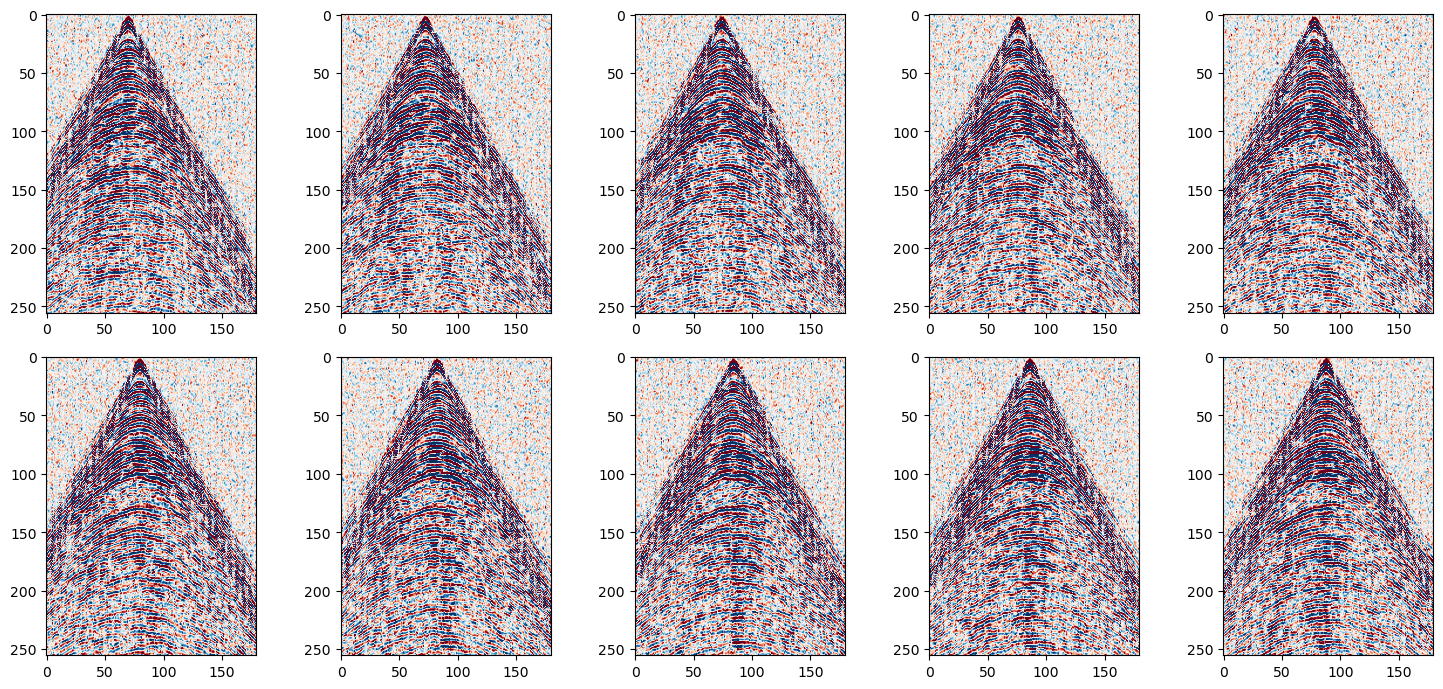

In [5]:
fig, axs = plt.subplots(2,5,figsize=[15,7])
for i in range(5*2):
    axs.ravel()[i].imshow(noisydata[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

### Patch data

At the moment we have a single image that we wish to denoise however to train the network we need to give it multiple data examples. Therefore, following common computer vision methodology, we will select random patches from the data for the networks training. 

Our patch implementation involves first regularly extracting patches from the image and then shuffling the patches such that they are in a random order. Later at the training stage these patches will be split into train and test dataset.

In [6]:
# Regularly extract patches from the noisy data
for i, shot in enumerate(noisydata):
    noisy_patches_shot = tu.regular_patching_2D(shot, 
                                                   patchsize=[64, 64], # dimensions of extracted patch
                                                   step=[4,6], # step to be taken in y,x for the extraction procedure
                                                   )
    if i==0: noisy_patches = noisy_patches_shot
    else: noisy_patches = np.concatenate([noisy_patches,noisy_patches_shot])


Extracting 960 patches
Extracting 960 patches
Extracting 960 patches
Extracting 960 patches
Extracting 960 patches
Extracting 960 patches
Extracting 960 patches
Extracting 960 patches
Extracting 960 patches
Extracting 960 patches


In [7]:
# Drop bottom 10% as it's important that patch has adequate signal for training
noisy_patches = tu.patch_selection(noisy_patches)

# Randomise patch order
shuffler = np.random.permutation(len(noisy_patches))
noisy_patches = noisy_patches[shuffler] 

2400 patches removed, 7200 patches remaining


#### Visualise the training patches

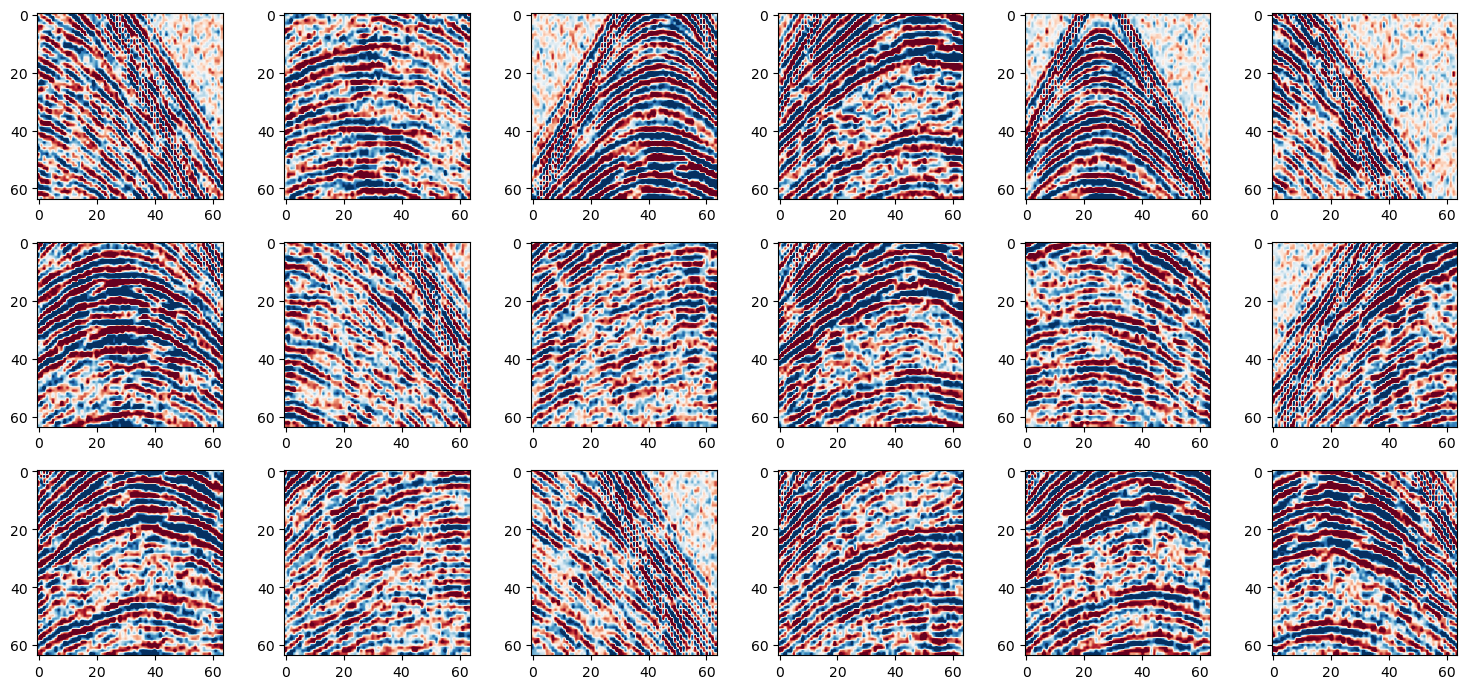

In [8]:
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

***

# Step Two - Blindspot corruption of training data

Now we have made our noisy data into patches such that we have an adequate number to train the network, we now need to pre-process these noisy patches prior to being input into the network. 

Our implementation of the preprocessing involves:

    - selecting the active pixels 
    - selecting the neighbourhood pixel for each active pixel, which it will take the value of
    - replacing each active pixels' value with its neighbourhood pixels' value
    - creating a active pixel 'mask' which shows the location of the active pixels on the patch
    
The first three steps are important for the pre-processing of the noisy patches, whilst the fourth step is required for identifying the locations on which to compute the loss function during training.

### Write your trace corruption function

In [9]:
def blind_trace_corruption(patch, 
                           num_activepixels, 
                           noise_level=0.5,
                          ):
    """ Function to identify multiple active pixels and replace with values from a random distribution

    Parameters
    ----------
    patch : numpy 2D array
        Noisy patch of data to be processed
    num_activepixels : int
        Number of active pixels to be selected within the patch
    NoiseLevel : float
        Random values from a uniform distribution over
        [-NoiseLevel, NoiseLevel] will be used to corrupt the traces belonging to the active pixels
        to generate the corrupted data

    Returns
    -------
        cp_ptch : numpy 2D array
            Processed patch
        mask : numpy 2D array
            Mask showing location of corrupted traces within the patch
    """

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    # STEP ONE: SELECT ACTIVE TRACE LOCATIONS
    active_traces_indices = np.random.choice(np.arange(patch.shape[1]), size=num_activepixels)

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    # STEP TWO: REPLACE ACTIVE TRACE's VALUES
    cp_ptch = patch.copy()
    cp_ptch[:, active_traces_indices] = np.random.rand(patch.shape[0], num_activepixels) * (noise_level * 2) - noise_level

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    # STEP THREE: GENERATE LOSS MASK
    mask = np.ones_like(patch)
    mask[:, active_traces_indices] = 0

    return cp_ptch, mask

#### Check the corruption function still works as expected

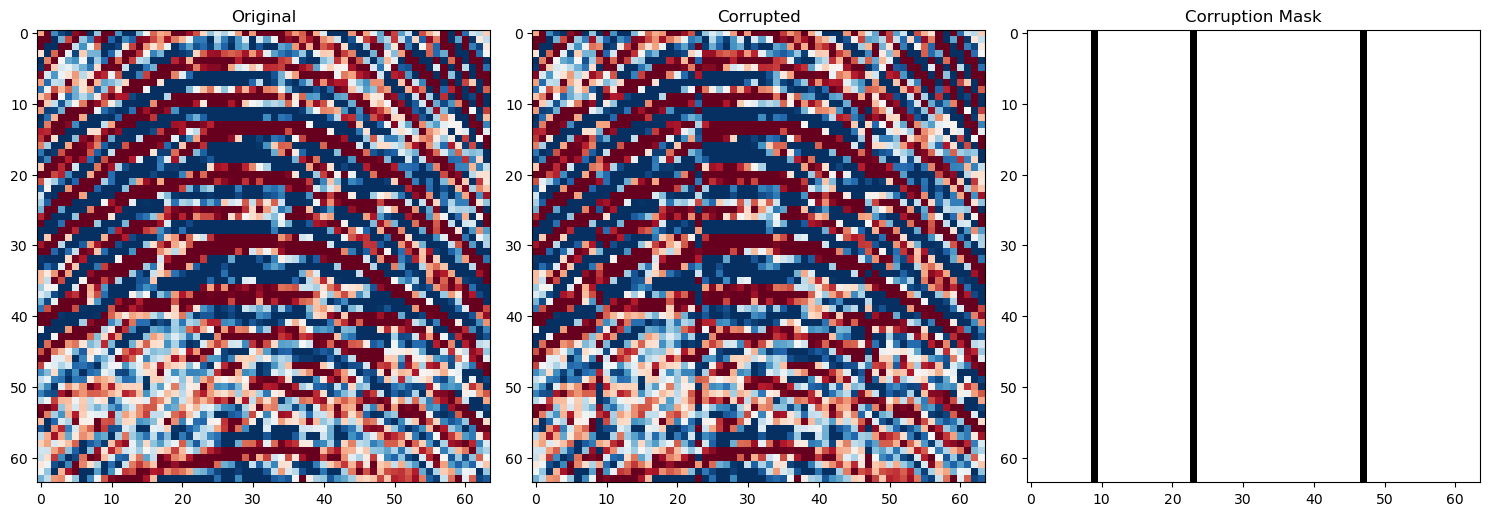

In [10]:
# Input the values of your choice into your pre-processing function
crpt_patch, mask = blind_trace_corruption(noisy_patches[6], 
                                       num_activepixels=3, 
                                      )

# Use the pre-made plotting function to visualise the corruption
fig,axs = pu.plot_corruption(noisy_patches[6], crpt_patch, mask)

#### TO DO: SELECT THE NUMBER OF ACTIVE PIXELS (AS PERCENTAGE)
For seismic field data, the i.i.d. assumption for blind-spot networks is often void, due to weak coherency in seismic random noise. [Birnie et al., 2021](https://doi.org/10.1016/j.aiig.2021.11.001) showed how that assumption can be 'loosened' when working with seismic field data by increasing the number of active pixels and severely decreasing the number of training epochs.

For this tutorial, first try running the procedure with the original N2V params of 2% active pixels and 200 epochs, then repeat with 33% active pixels and only 25 epochs. 

In [11]:
num_activepixels = 3


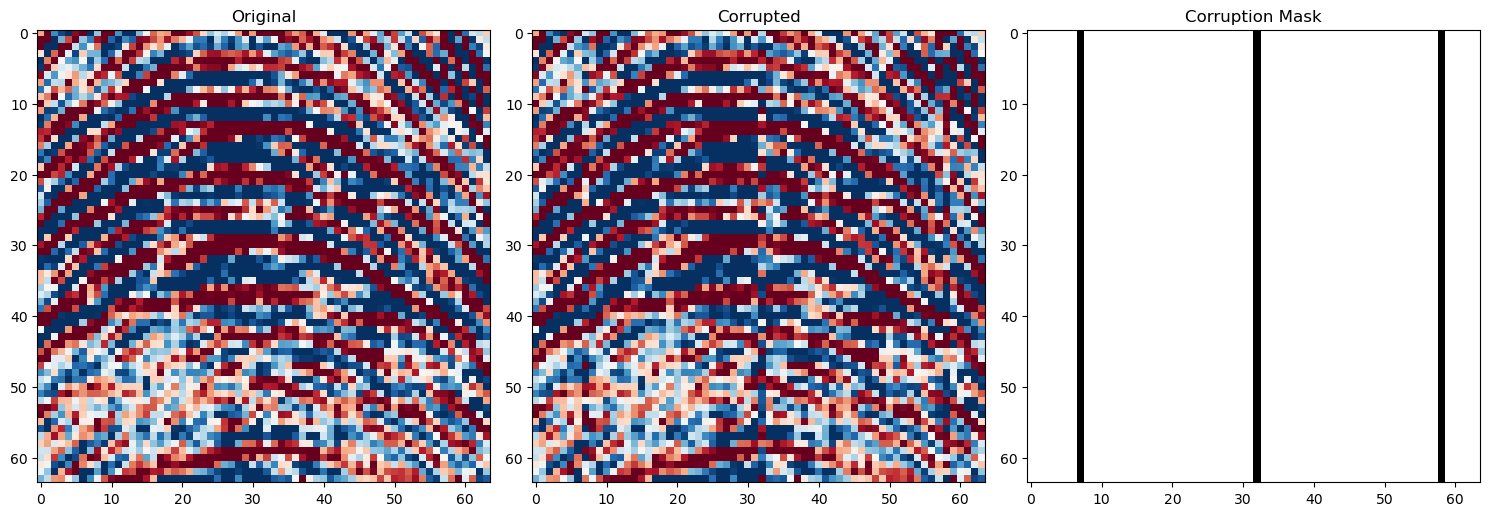

In [12]:
# Input the values of your choice into your pre-processing function
crpt_patch, mask = blind_trace_corruption(noisy_patches[6], 
                                         num_activepixels=num_activepixels, 
                                         )

# Visulise the coverage of active pixels within a patch
fig,axs = pu.plot_corruption(noisy_patches[6], crpt_patch, mask)

***

# Step three - Set up network

In the N2V application of Krull et al., 2018, the network is not specially tailored to the blindspot task. As such, in theory any network could be used that goes from one input image to another of the same size.

In this example, like in Krull et al., 2018 and Birnie et al., 2021's seismic application, we will use a standard UNet architecture. As the architecture is independent to the blind-spot denoising procedure presented, it will be created via functions as opposed to being wrote within the notebook. 

In [13]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
elif torch.backends.mps.is_available(): 
    print("M1 installed! Running on M1!")
    device = torch.device("mps")
else:
    print("No GPU available!")

M1 installed! Running on M1!


#### Build the network

In [14]:
# Build UNet from pre-made function
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)
# Initialise UNet's weights from pre-made function
network = network.apply(tu.weights_init) 

#### Select the networks training parameters

In [15]:
lr = 0.0001  # Learning rate
criterion = nn.MSELoss()  # Loss function
optim = torch.optim.Adam(network.parameters(), lr=lr)  # Optimiser

***

# Step four - Network Training

Now we have successfully built our network and prepared our data - by patching it to get adequate training samples and creating the input data by selecting and corrupting the active pixels. We are now ready to train the network.

Remember, the network training is slightly different to standard image processing tasks in that we will only be computing the loss on the active pixels.

#### TO DO: DEFINE TRAINING PARAMETERS

In [16]:
# Choose the number of epochs
n_epochs = 200

# Choose number of training and validation samples
n_training = 2048
n_test = 512

# Choose the batch size for the networks training
batch_size = 128

In [17]:
# Initialise arrays to keep track of train and validation metrics
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
test_accuracy_history = np.zeros(n_epochs)

# Create torch generator with fixed seed for reproducibility, to be used with the data loaders
g = torch.Generator()
g.manual_seed(0)

## Import the training and evaluation functions that we wrote in tutorial 1

In [18]:
from ssdn_functions import n2v_train, n2v_evaluate

#### TO DO: COMPLETE TRAINING LOOP BY CORRUPTION AND NETWORK FUNCTIONS

In [19]:
# TRAINING
for ep in range(n_epochs):  
        
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        
        # TO DO: USE ACTIVE PIXEL FUNCTION TO COMPUTE INPUT DATA AND MASKS
        # Hint: One line of code
        corrupted_patches[pi], masks[pi] = blind_trace_corruption(noisy_patches[pi], 
                                                               num_activepixels=num_activepixels,  
                                                              )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # MAKE DATA LOADERS - using pre-made function 
    train_loader, test_loader = tu.make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = batch_size,
                                                 torch_generator=g
                                                )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    # TO DO: Incorporate n2v_train function
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)
    # Keeping track of training metrics
    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # EVALUATE (AKA VALIDATION)
    # TO DO: Incorporate n2v_evaluate function
    test_loss, test_accuracy = n2v_evaluate(network, 
                                            criterion,
                                            optim,
                                            test_loader, 
                                            device,)
    # Keeping track of validation metrics
    test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # PRINTING TRAINING PROGRESS
    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, 
    Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')

torch.save(network, os.path.join(networks_dir,'Tutorial3_SyntheticBlindtrace200epochs.net'))

100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch 0, 
    Training Loss 0.0022,     Training Accuracy 0.2260, 
    Test Loss 0.0019,     Test Accuracy 0.2128 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Epoch 1, 
    Training Loss 0.0018,     Training Accuracy 0.2085, 
    Test Loss 0.0016,     Test Accuracy 0.1971 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.62it/s]


Epoch 2, 
    Training Loss 0.0015,     Training Accuracy 0.1871, 
    Test Loss 0.0014,     Test Accuracy 0.1753 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Epoch 3, 
    Training Loss 0.0013,     Training Accuracy 0.1698, 
    Test Loss 0.0012,     Test Accuracy 0.1623 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.06it/s]


Epoch 4, 
    Training Loss 0.0011,     Training Accuracy 0.1586, 
    Test Loss 0.0011,     Test Accuracy 0.1506 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.76it/s]


Epoch 5, 
    Training Loss 0.0010,     Training Accuracy 0.1478, 
    Test Loss 0.0009,     Test Accuracy 0.1413 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Epoch 6, 
    Training Loss 0.0009,     Training Accuracy 0.1385, 
    Test Loss 0.0008,     Test Accuracy 0.1325 


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Epoch 7, 
    Training Loss 0.0008,     Training Accuracy 0.1317, 
    Test Loss 0.0008,     Test Accuracy 0.1275 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Epoch 8, 
    Training Loss 0.0007,     Training Accuracy 0.1272, 
    Test Loss 0.0007,     Test Accuracy 0.1242 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.35it/s]


Epoch 9, 
    Training Loss 0.0007,     Training Accuracy 0.1239, 
    Test Loss 0.0007,     Test Accuracy 0.1212 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.75it/s]


Epoch 10, 
    Training Loss 0.0007,     Training Accuracy 0.1217, 
    Test Loss 0.0007,     Test Accuracy 0.1197 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.44it/s]


Epoch 11, 
    Training Loss 0.0007,     Training Accuracy 0.1202, 
    Test Loss 0.0006,     Test Accuracy 0.1188 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.26it/s]


Epoch 12, 
    Training Loss 0.0006,     Training Accuracy 0.1190, 
    Test Loss 0.0006,     Test Accuracy 0.1175 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 13, 
    Training Loss 0.0006,     Training Accuracy 0.1182, 
    Test Loss 0.0006,     Test Accuracy 0.1169 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.44it/s]


Epoch 14, 
    Training Loss 0.0006,     Training Accuracy 0.1180, 
    Test Loss 0.0006,     Test Accuracy 0.1164 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.50it/s]


Epoch 15, 
    Training Loss 0.0006,     Training Accuracy 0.1169, 
    Test Loss 0.0006,     Test Accuracy 0.1168 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.46it/s]


Epoch 16, 
    Training Loss 0.0006,     Training Accuracy 0.1169, 
    Test Loss 0.0006,     Test Accuracy 0.1161 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.35it/s]


Epoch 17, 
    Training Loss 0.0006,     Training Accuracy 0.1163, 
    Test Loss 0.0006,     Test Accuracy 0.1155 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.81it/s]


Epoch 18, 
    Training Loss 0.0006,     Training Accuracy 0.1162, 
    Test Loss 0.0006,     Test Accuracy 0.1152 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.04it/s]


Epoch 19, 
    Training Loss 0.0006,     Training Accuracy 0.1158, 
    Test Loss 0.0006,     Test Accuracy 0.1148 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.49it/s]


Epoch 20, 
    Training Loss 0.0006,     Training Accuracy 0.1156, 
    Test Loss 0.0006,     Test Accuracy 0.1152 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Epoch 21, 
    Training Loss 0.0006,     Training Accuracy 0.1154, 
    Test Loss 0.0006,     Test Accuracy 0.1146 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.56it/s]


Epoch 22, 
    Training Loss 0.0006,     Training Accuracy 0.1152, 
    Test Loss 0.0006,     Test Accuracy 0.1144 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.96it/s]


Epoch 23, 
    Training Loss 0.0006,     Training Accuracy 0.1151, 
    Test Loss 0.0006,     Test Accuracy 0.1140 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 24, 
    Training Loss 0.0006,     Training Accuracy 0.1150, 
    Test Loss 0.0006,     Test Accuracy 0.1144 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 25, 
    Training Loss 0.0006,     Training Accuracy 0.1146, 
    Test Loss 0.0006,     Test Accuracy 0.1137 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 26, 
    Training Loss 0.0006,     Training Accuracy 0.1144, 
    Test Loss 0.0006,     Test Accuracy 0.1134 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 27, 
    Training Loss 0.0006,     Training Accuracy 0.1140, 
    Test Loss 0.0006,     Test Accuracy 0.1136 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 28, 
    Training Loss 0.0006,     Training Accuracy 0.1141, 
    Test Loss 0.0006,     Test Accuracy 0.1134 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch 29, 
    Training Loss 0.0006,     Training Accuracy 0.1137, 
    Test Loss 0.0006,     Test Accuracy 0.1128 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 30, 
    Training Loss 0.0006,     Training Accuracy 0.1136, 
    Test Loss 0.0006,     Test Accuracy 0.1131 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.46it/s]


Epoch 31, 
    Training Loss 0.0006,     Training Accuracy 0.1136, 
    Test Loss 0.0006,     Test Accuracy 0.1126 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch 32, 
    Training Loss 0.0006,     Training Accuracy 0.1135, 
    Test Loss 0.0006,     Test Accuracy 0.1126 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.24it/s]


Epoch 33, 
    Training Loss 0.0006,     Training Accuracy 0.1131, 
    Test Loss 0.0006,     Test Accuracy 0.1126 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.89it/s]


Epoch 34, 
    Training Loss 0.0006,     Training Accuracy 0.1133, 
    Test Loss 0.0006,     Test Accuracy 0.1124 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch 35, 
    Training Loss 0.0006,     Training Accuracy 0.1129, 
    Test Loss 0.0006,     Test Accuracy 0.1123 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.28it/s]


Epoch 36, 
    Training Loss 0.0006,     Training Accuracy 0.1131, 
    Test Loss 0.0006,     Test Accuracy 0.1124 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.57it/s]


Epoch 37, 
    Training Loss 0.0006,     Training Accuracy 0.1128, 
    Test Loss 0.0006,     Test Accuracy 0.1125 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 38, 
    Training Loss 0.0006,     Training Accuracy 0.1129, 
    Test Loss 0.0006,     Test Accuracy 0.1117 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]


Epoch 39, 
    Training Loss 0.0006,     Training Accuracy 0.1126, 
    Test Loss 0.0006,     Test Accuracy 0.1122 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.59it/s]


Epoch 40, 
    Training Loss 0.0006,     Training Accuracy 0.1125, 
    Test Loss 0.0006,     Test Accuracy 0.1124 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.45it/s]


Epoch 41, 
    Training Loss 0.0006,     Training Accuracy 0.1123, 
    Test Loss 0.0006,     Test Accuracy 0.1115 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.89it/s]


Epoch 42, 
    Training Loss 0.0006,     Training Accuracy 0.1123, 
    Test Loss 0.0006,     Test Accuracy 0.1118 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 43, 
    Training Loss 0.0006,     Training Accuracy 0.1123, 
    Test Loss 0.0005,     Test Accuracy 0.1116 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.90it/s]


Epoch 44, 
    Training Loss 0.0006,     Training Accuracy 0.1121, 
    Test Loss 0.0006,     Test Accuracy 0.1114 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.30it/s]


Epoch 45, 
    Training Loss 0.0006,     Training Accuracy 0.1122, 
    Test Loss 0.0006,     Test Accuracy 0.1110 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.22it/s]


Epoch 46, 
    Training Loss 0.0006,     Training Accuracy 0.1120, 
    Test Loss 0.0006,     Test Accuracy 0.1114 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch 47, 
    Training Loss 0.0006,     Training Accuracy 0.1119, 
    Test Loss 0.0006,     Test Accuracy 0.1111 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.45it/s]


Epoch 48, 
    Training Loss 0.0006,     Training Accuracy 0.1116, 
    Test Loss 0.0005,     Test Accuracy 0.1109 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.82it/s]


Epoch 49, 
    Training Loss 0.0006,     Training Accuracy 0.1115, 
    Test Loss 0.0006,     Test Accuracy 0.1110 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.80it/s]


Epoch 50, 
    Training Loss 0.0006,     Training Accuracy 0.1116, 
    Test Loss 0.0005,     Test Accuracy 0.1109 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.80it/s]


Epoch 51, 
    Training Loss 0.0006,     Training Accuracy 0.1115, 
    Test Loss 0.0006,     Test Accuracy 0.1109 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch 52, 
    Training Loss 0.0006,     Training Accuracy 0.1115, 
    Test Loss 0.0005,     Test Accuracy 0.1105 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch 53, 
    Training Loss 0.0006,     Training Accuracy 0.1115, 
    Test Loss 0.0005,     Test Accuracy 0.1109 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.83it/s]


Epoch 54, 
    Training Loss 0.0005,     Training Accuracy 0.1112, 
    Test Loss 0.0006,     Test Accuracy 0.1109 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.80it/s]


Epoch 55, 
    Training Loss 0.0006,     Training Accuracy 0.1114, 
    Test Loss 0.0005,     Test Accuracy 0.1109 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 56, 
    Training Loss 0.0006,     Training Accuracy 0.1111, 
    Test Loss 0.0005,     Test Accuracy 0.1100 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.87it/s]


Epoch 57, 
    Training Loss 0.0005,     Training Accuracy 0.1111, 
    Test Loss 0.0005,     Test Accuracy 0.1102 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch 58, 
    Training Loss 0.0006,     Training Accuracy 0.1109, 
    Test Loss 0.0005,     Test Accuracy 0.1102 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.83it/s]


Epoch 59, 
    Training Loss 0.0005,     Training Accuracy 0.1107, 
    Test Loss 0.0005,     Test Accuracy 0.1103 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch 60, 
    Training Loss 0.0006,     Training Accuracy 0.1108, 
    Test Loss 0.0005,     Test Accuracy 0.1101 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch 61, 
    Training Loss 0.0006,     Training Accuracy 0.1108, 
    Test Loss 0.0006,     Test Accuracy 0.1101 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch 62, 
    Training Loss 0.0005,     Training Accuracy 0.1107, 
    Test Loss 0.0005,     Test Accuracy 0.1099 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.92it/s]


Epoch 63, 
    Training Loss 0.0005,     Training Accuracy 0.1106, 
    Test Loss 0.0005,     Test Accuracy 0.1097 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.39it/s]


Epoch 64, 
    Training Loss 0.0005,     Training Accuracy 0.1102, 
    Test Loss 0.0005,     Test Accuracy 0.1097 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 65, 
    Training Loss 0.0006,     Training Accuracy 0.1104, 
    Test Loss 0.0005,     Test Accuracy 0.1099 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 66, 
    Training Loss 0.0005,     Training Accuracy 0.1104, 
    Test Loss 0.0005,     Test Accuracy 0.1103 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.90it/s]


Epoch 67, 
    Training Loss 0.0006,     Training Accuracy 0.1104, 
    Test Loss 0.0005,     Test Accuracy 0.1097 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch 68, 
    Training Loss 0.0005,     Training Accuracy 0.1102, 
    Test Loss 0.0005,     Test Accuracy 0.1092 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 69, 
    Training Loss 0.0005,     Training Accuracy 0.1101, 
    Test Loss 0.0006,     Test Accuracy 0.1099 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 70, 
    Training Loss 0.0005,     Training Accuracy 0.1101, 
    Test Loss 0.0005,     Test Accuracy 0.1097 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.82it/s]


Epoch 71, 
    Training Loss 0.0005,     Training Accuracy 0.1102, 
    Test Loss 0.0005,     Test Accuracy 0.1097 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.47it/s]


Epoch 72, 
    Training Loss 0.0005,     Training Accuracy 0.1102, 
    Test Loss 0.0005,     Test Accuracy 0.1094 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.90it/s]


Epoch 73, 
    Training Loss 0.0005,     Training Accuracy 0.1101, 
    Test Loss 0.0005,     Test Accuracy 0.1099 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.60it/s]


Epoch 74, 
    Training Loss 0.0005,     Training Accuracy 0.1101, 
    Test Loss 0.0005,     Test Accuracy 0.1089 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch 75, 
    Training Loss 0.0005,     Training Accuracy 0.1099, 
    Test Loss 0.0005,     Test Accuracy 0.1095 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.82it/s]


Epoch 76, 
    Training Loss 0.0005,     Training Accuracy 0.1098, 
    Test Loss 0.0005,     Test Accuracy 0.1099 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch 77, 
    Training Loss 0.0005,     Training Accuracy 0.1099, 
    Test Loss 0.0005,     Test Accuracy 0.1094 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 78, 
    Training Loss 0.0005,     Training Accuracy 0.1097, 
    Test Loss 0.0005,     Test Accuracy 0.1089 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch 79, 
    Training Loss 0.0005,     Training Accuracy 0.1098, 
    Test Loss 0.0005,     Test Accuracy 0.1093 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.40it/s]


Epoch 80, 
    Training Loss 0.0005,     Training Accuracy 0.1099, 
    Test Loss 0.0005,     Test Accuracy 0.1088 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch 81, 
    Training Loss 0.0005,     Training Accuracy 0.1096, 
    Test Loss 0.0005,     Test Accuracy 0.1089 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.92it/s]


Epoch 82, 
    Training Loss 0.0005,     Training Accuracy 0.1094, 
    Test Loss 0.0005,     Test Accuracy 0.1093 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch 83, 
    Training Loss 0.0005,     Training Accuracy 0.1097, 
    Test Loss 0.0005,     Test Accuracy 0.1089 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.39it/s]


Epoch 84, 
    Training Loss 0.0005,     Training Accuracy 0.1094, 
    Test Loss 0.0005,     Test Accuracy 0.1090 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch 85, 
    Training Loss 0.0005,     Training Accuracy 0.1096, 
    Test Loss 0.0005,     Test Accuracy 0.1085 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Epoch 86, 
    Training Loss 0.0005,     Training Accuracy 0.1091, 
    Test Loss 0.0005,     Test Accuracy 0.1095 


100%|█████████████████████████████████████████████| 4/4 [00:26<00:00,  6.58s/it]


Epoch 87, 
    Training Loss 0.0005,     Training Accuracy 0.1096, 
    Test Loss 0.0005,     Test Accuracy 0.1091 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.61it/s]


Epoch 88, 
    Training Loss 0.0005,     Training Accuracy 0.1093, 
    Test Loss 0.0005,     Test Accuracy 0.1090 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 89, 
    Training Loss 0.0005,     Training Accuracy 0.1093, 
    Test Loss 0.0005,     Test Accuracy 0.1089 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.36it/s]


Epoch 90, 
    Training Loss 0.0005,     Training Accuracy 0.1093, 
    Test Loss 0.0005,     Test Accuracy 0.1083 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 91, 
    Training Loss 0.0005,     Training Accuracy 0.1091, 
    Test Loss 0.0005,     Test Accuracy 0.1083 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 92, 
    Training Loss 0.0005,     Training Accuracy 0.1089, 
    Test Loss 0.0005,     Test Accuracy 0.1086 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.92it/s]


Epoch 93, 
    Training Loss 0.0005,     Training Accuracy 0.1090, 
    Test Loss 0.0005,     Test Accuracy 0.1089 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 94, 
    Training Loss 0.0005,     Training Accuracy 0.1091, 
    Test Loss 0.0005,     Test Accuracy 0.1084 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.92it/s]


Epoch 95, 
    Training Loss 0.0005,     Training Accuracy 0.1089, 
    Test Loss 0.0005,     Test Accuracy 0.1082 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch 96, 
    Training Loss 0.0005,     Training Accuracy 0.1086, 
    Test Loss 0.0005,     Test Accuracy 0.1083 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.40it/s]


Epoch 97, 
    Training Loss 0.0005,     Training Accuracy 0.1089, 
    Test Loss 0.0005,     Test Accuracy 0.1083 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 98, 
    Training Loss 0.0005,     Training Accuracy 0.1088, 
    Test Loss 0.0005,     Test Accuracy 0.1084 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.61it/s]


Epoch 99, 
    Training Loss 0.0005,     Training Accuracy 0.1089, 
    Test Loss 0.0005,     Test Accuracy 0.1083 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.62it/s]


Epoch 100, 
    Training Loss 0.0005,     Training Accuracy 0.1085, 
    Test Loss 0.0005,     Test Accuracy 0.1082 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 101, 
    Training Loss 0.0005,     Training Accuracy 0.1086, 
    Test Loss 0.0005,     Test Accuracy 0.1084 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.62it/s]


Epoch 102, 
    Training Loss 0.0005,     Training Accuracy 0.1086, 
    Test Loss 0.0005,     Test Accuracy 0.1079 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.70it/s]


Epoch 103, 
    Training Loss 0.0005,     Training Accuracy 0.1085, 
    Test Loss 0.0005,     Test Accuracy 0.1081 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch 104, 
    Training Loss 0.0005,     Training Accuracy 0.1086, 
    Test Loss 0.0005,     Test Accuracy 0.1082 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.51it/s]


Epoch 105, 
    Training Loss 0.0005,     Training Accuracy 0.1086, 
    Test Loss 0.0005,     Test Accuracy 0.1080 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.50it/s]


Epoch 106, 
    Training Loss 0.0005,     Training Accuracy 0.1086, 
    Test Loss 0.0005,     Test Accuracy 0.1078 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.61it/s]


Epoch 107, 
    Training Loss 0.0005,     Training Accuracy 0.1083, 
    Test Loss 0.0005,     Test Accuracy 0.1080 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.45it/s]


Epoch 108, 
    Training Loss 0.0005,     Training Accuracy 0.1081, 
    Test Loss 0.0005,     Test Accuracy 0.1078 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 109, 
    Training Loss 0.0005,     Training Accuracy 0.1082, 
    Test Loss 0.0005,     Test Accuracy 0.1079 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Epoch 110, 
    Training Loss 0.0005,     Training Accuracy 0.1082, 
    Test Loss 0.0005,     Test Accuracy 0.1075 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.56it/s]


Epoch 111, 
    Training Loss 0.0005,     Training Accuracy 0.1084, 
    Test Loss 0.0005,     Test Accuracy 0.1075 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.04it/s]


Epoch 112, 
    Training Loss 0.0005,     Training Accuracy 0.1083, 
    Test Loss 0.0005,     Test Accuracy 0.1076 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.35it/s]


Epoch 113, 
    Training Loss 0.0005,     Training Accuracy 0.1081, 
    Test Loss 0.0005,     Test Accuracy 0.1078 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch 114, 
    Training Loss 0.0005,     Training Accuracy 0.1081, 
    Test Loss 0.0005,     Test Accuracy 0.1079 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch 115, 
    Training Loss 0.0005,     Training Accuracy 0.1081, 
    Test Loss 0.0005,     Test Accuracy 0.1081 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.51it/s]


Epoch 116, 
    Training Loss 0.0005,     Training Accuracy 0.1083, 
    Test Loss 0.0005,     Test Accuracy 0.1076 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 117, 
    Training Loss 0.0005,     Training Accuracy 0.1080, 
    Test Loss 0.0005,     Test Accuracy 0.1077 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.58it/s]


Epoch 118, 
    Training Loss 0.0005,     Training Accuracy 0.1080, 
    Test Loss 0.0005,     Test Accuracy 0.1076 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Epoch 119, 
    Training Loss 0.0005,     Training Accuracy 0.1080, 
    Test Loss 0.0005,     Test Accuracy 0.1069 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.62it/s]


Epoch 120, 
    Training Loss 0.0005,     Training Accuracy 0.1078, 
    Test Loss 0.0005,     Test Accuracy 0.1078 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.56it/s]


Epoch 121, 
    Training Loss 0.0005,     Training Accuracy 0.1077, 
    Test Loss 0.0005,     Test Accuracy 0.1077 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.51it/s]


Epoch 122, 
    Training Loss 0.0005,     Training Accuracy 0.1079, 
    Test Loss 0.0005,     Test Accuracy 0.1076 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.34it/s]


Epoch 123, 
    Training Loss 0.0005,     Training Accuracy 0.1077, 
    Test Loss 0.0005,     Test Accuracy 0.1073 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch 124, 
    Training Loss 0.0005,     Training Accuracy 0.1077, 
    Test Loss 0.0005,     Test Accuracy 0.1069 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.98it/s]


Epoch 125, 
    Training Loss 0.0005,     Training Accuracy 0.1079, 
    Test Loss 0.0005,     Test Accuracy 0.1077 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.54it/s]


Epoch 126, 
    Training Loss 0.0005,     Training Accuracy 0.1076, 
    Test Loss 0.0005,     Test Accuracy 0.1073 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.02it/s]


Epoch 127, 
    Training Loss 0.0005,     Training Accuracy 0.1078, 
    Test Loss 0.0005,     Test Accuracy 0.1073 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.32it/s]


Epoch 128, 
    Training Loss 0.0005,     Training Accuracy 0.1077, 
    Test Loss 0.0005,     Test Accuracy 0.1070 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.41it/s]


Epoch 129, 
    Training Loss 0.0005,     Training Accuracy 0.1078, 
    Test Loss 0.0005,     Test Accuracy 0.1074 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.60it/s]


Epoch 130, 
    Training Loss 0.0005,     Training Accuracy 0.1076, 
    Test Loss 0.0005,     Test Accuracy 0.1073 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.98it/s]


Epoch 131, 
    Training Loss 0.0005,     Training Accuracy 0.1076, 
    Test Loss 0.0005,     Test Accuracy 0.1074 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.57it/s]


Epoch 132, 
    Training Loss 0.0005,     Training Accuracy 0.1072, 
    Test Loss 0.0005,     Test Accuracy 0.1073 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.13it/s]


Epoch 133, 
    Training Loss 0.0005,     Training Accuracy 0.1076, 
    Test Loss 0.0005,     Test Accuracy 0.1064 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.05it/s]


Epoch 134, 
    Training Loss 0.0005,     Training Accuracy 0.1073, 
    Test Loss 0.0005,     Test Accuracy 0.1069 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.46it/s]


Epoch 135, 
    Training Loss 0.0005,     Training Accuracy 0.1074, 
    Test Loss 0.0005,     Test Accuracy 0.1071 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.63it/s]


Epoch 136, 
    Training Loss 0.0005,     Training Accuracy 0.1074, 
    Test Loss 0.0005,     Test Accuracy 0.1074 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch 137, 
    Training Loss 0.0005,     Training Accuracy 0.1073, 
    Test Loss 0.0005,     Test Accuracy 0.1069 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch 138, 
    Training Loss 0.0005,     Training Accuracy 0.1072, 
    Test Loss 0.0005,     Test Accuracy 0.1069 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.57it/s]


Epoch 139, 
    Training Loss 0.0005,     Training Accuracy 0.1073, 
    Test Loss 0.0005,     Test Accuracy 0.1068 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 140, 
    Training Loss 0.0005,     Training Accuracy 0.1073, 
    Test Loss 0.0005,     Test Accuracy 0.1068 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch 141, 
    Training Loss 0.0005,     Training Accuracy 0.1071, 
    Test Loss 0.0005,     Test Accuracy 0.1066 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch 142, 
    Training Loss 0.0005,     Training Accuracy 0.1072, 
    Test Loss 0.0005,     Test Accuracy 0.1068 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch 143, 
    Training Loss 0.0005,     Training Accuracy 0.1073, 
    Test Loss 0.0005,     Test Accuracy 0.1061 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 144, 
    Training Loss 0.0005,     Training Accuracy 0.1071, 
    Test Loss 0.0005,     Test Accuracy 0.1061 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.21it/s]


Epoch 145, 
    Training Loss 0.0005,     Training Accuracy 0.1069, 
    Test Loss 0.0005,     Test Accuracy 0.1068 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch 146, 
    Training Loss 0.0005,     Training Accuracy 0.1068, 
    Test Loss 0.0005,     Test Accuracy 0.1067 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.19it/s]


Epoch 147, 
    Training Loss 0.0005,     Training Accuracy 0.1071, 
    Test Loss 0.0005,     Test Accuracy 0.1067 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.80it/s]


Epoch 148, 
    Training Loss 0.0005,     Training Accuracy 0.1070, 
    Test Loss 0.0005,     Test Accuracy 0.1066 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch 149, 
    Training Loss 0.0005,     Training Accuracy 0.1069, 
    Test Loss 0.0005,     Test Accuracy 0.1068 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 150, 
    Training Loss 0.0005,     Training Accuracy 0.1070, 
    Test Loss 0.0005,     Test Accuracy 0.1066 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch 151, 
    Training Loss 0.0005,     Training Accuracy 0.1071, 
    Test Loss 0.0005,     Test Accuracy 0.1061 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 152, 
    Training Loss 0.0005,     Training Accuracy 0.1067, 
    Test Loss 0.0005,     Test Accuracy 0.1062 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 153, 
    Training Loss 0.0005,     Training Accuracy 0.1065, 
    Test Loss 0.0005,     Test Accuracy 0.1058 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.82it/s]


Epoch 154, 
    Training Loss 0.0005,     Training Accuracy 0.1067, 
    Test Loss 0.0005,     Test Accuracy 0.1063 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.61it/s]


Epoch 155, 
    Training Loss 0.0005,     Training Accuracy 0.1068, 
    Test Loss 0.0005,     Test Accuracy 0.1060 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.63it/s]


Epoch 156, 
    Training Loss 0.0005,     Training Accuracy 0.1070, 
    Test Loss 0.0005,     Test Accuracy 0.1059 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 157, 
    Training Loss 0.0005,     Training Accuracy 0.1068, 
    Test Loss 0.0005,     Test Accuracy 0.1063 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 158, 
    Training Loss 0.0005,     Training Accuracy 0.1064, 
    Test Loss 0.0005,     Test Accuracy 0.1063 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch 159, 
    Training Loss 0.0005,     Training Accuracy 0.1066, 
    Test Loss 0.0005,     Test Accuracy 0.1062 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.57it/s]


Epoch 160, 
    Training Loss 0.0005,     Training Accuracy 0.1068, 
    Test Loss 0.0005,     Test Accuracy 0.1060 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch 161, 
    Training Loss 0.0005,     Training Accuracy 0.1068, 
    Test Loss 0.0005,     Test Accuracy 0.1061 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 162, 
    Training Loss 0.0005,     Training Accuracy 0.1068, 
    Test Loss 0.0005,     Test Accuracy 0.1065 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch 163, 
    Training Loss 0.0005,     Training Accuracy 0.1064, 
    Test Loss 0.0005,     Test Accuracy 0.1062 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch 164, 
    Training Loss 0.0005,     Training Accuracy 0.1064, 
    Test Loss 0.0005,     Test Accuracy 0.1060 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.46it/s]


Epoch 165, 
    Training Loss 0.0005,     Training Accuracy 0.1065, 
    Test Loss 0.0005,     Test Accuracy 0.1059 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch 166, 
    Training Loss 0.0005,     Training Accuracy 0.1066, 
    Test Loss 0.0005,     Test Accuracy 0.1061 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.89it/s]


Epoch 167, 
    Training Loss 0.0005,     Training Accuracy 0.1065, 
    Test Loss 0.0005,     Test Accuracy 0.1057 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch 168, 
    Training Loss 0.0005,     Training Accuracy 0.1064, 
    Test Loss 0.0005,     Test Accuracy 0.1064 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 169, 
    Training Loss 0.0005,     Training Accuracy 0.1064, 
    Test Loss 0.0005,     Test Accuracy 0.1056 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.62it/s]


Epoch 170, 
    Training Loss 0.0005,     Training Accuracy 0.1062, 
    Test Loss 0.0005,     Test Accuracy 0.1058 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 171, 
    Training Loss 0.0005,     Training Accuracy 0.1063, 
    Test Loss 0.0005,     Test Accuracy 0.1058 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 172, 
    Training Loss 0.0005,     Training Accuracy 0.1062, 
    Test Loss 0.0005,     Test Accuracy 0.1065 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch 173, 
    Training Loss 0.0005,     Training Accuracy 0.1062, 
    Test Loss 0.0005,     Test Accuracy 0.1055 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 174, 
    Training Loss 0.0005,     Training Accuracy 0.1061, 
    Test Loss 0.0005,     Test Accuracy 0.1057 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.46it/s]


Epoch 175, 
    Training Loss 0.0005,     Training Accuracy 0.1061, 
    Test Loss 0.0005,     Test Accuracy 0.1057 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 176, 
    Training Loss 0.0005,     Training Accuracy 0.1058, 
    Test Loss 0.0005,     Test Accuracy 0.1059 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.85it/s]


Epoch 177, 
    Training Loss 0.0005,     Training Accuracy 0.1062, 
    Test Loss 0.0005,     Test Accuracy 0.1059 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch 178, 
    Training Loss 0.0005,     Training Accuracy 0.1063, 
    Test Loss 0.0005,     Test Accuracy 0.1051 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.82it/s]


Epoch 179, 
    Training Loss 0.0005,     Training Accuracy 0.1062, 
    Test Loss 0.0005,     Test Accuracy 0.1057 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 180, 
    Training Loss 0.0005,     Training Accuracy 0.1060, 
    Test Loss 0.0005,     Test Accuracy 0.1055 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.87it/s]


Epoch 181, 
    Training Loss 0.0005,     Training Accuracy 0.1057, 
    Test Loss 0.0005,     Test Accuracy 0.1061 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch 182, 
    Training Loss 0.0005,     Training Accuracy 0.1059, 
    Test Loss 0.0005,     Test Accuracy 0.1059 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.46it/s]


Epoch 183, 
    Training Loss 0.0005,     Training Accuracy 0.1057, 
    Test Loss 0.0005,     Test Accuracy 0.1060 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 184, 
    Training Loss 0.0005,     Training Accuracy 0.1059, 
    Test Loss 0.0005,     Test Accuracy 0.1052 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch 185, 
    Training Loss 0.0005,     Training Accuracy 0.1057, 
    Test Loss 0.0005,     Test Accuracy 0.1052 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.42it/s]


Epoch 186, 
    Training Loss 0.0005,     Training Accuracy 0.1058, 
    Test Loss 0.0005,     Test Accuracy 0.1055 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.53it/s]


Epoch 187, 
    Training Loss 0.0005,     Training Accuracy 0.1057, 
    Test Loss 0.0005,     Test Accuracy 0.1058 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.83it/s]


Epoch 188, 
    Training Loss 0.0005,     Training Accuracy 0.1058, 
    Test Loss 0.0005,     Test Accuracy 0.1060 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch 189, 
    Training Loss 0.0005,     Training Accuracy 0.1055, 
    Test Loss 0.0005,     Test Accuracy 0.1050 


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.84it/s]


Epoch 190, 
    Training Loss 0.0005,     Training Accuracy 0.1057, 
    Test Loss 0.0005,     Test Accuracy 0.1050 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.11it/s]


Epoch 191, 
    Training Loss 0.0005,     Training Accuracy 0.1056, 
    Test Loss 0.0005,     Test Accuracy 0.1050 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch 192, 
    Training Loss 0.0005,     Training Accuracy 0.1057, 
    Test Loss 0.0005,     Test Accuracy 0.1046 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.87it/s]


Epoch 193, 
    Training Loss 0.0005,     Training Accuracy 0.1056, 
    Test Loss 0.0005,     Test Accuracy 0.1055 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 194, 
    Training Loss 0.0005,     Training Accuracy 0.1055, 
    Test Loss 0.0005,     Test Accuracy 0.1050 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch 195, 
    Training Loss 0.0005,     Training Accuracy 0.1054, 
    Test Loss 0.0005,     Test Accuracy 0.1052 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 196, 
    Training Loss 0.0005,     Training Accuracy 0.1055, 
    Test Loss 0.0005,     Test Accuracy 0.1049 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch 197, 
    Training Loss 0.0005,     Training Accuracy 0.1056, 
    Test Loss 0.0005,     Test Accuracy 0.1049 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.52it/s]


Epoch 198, 
    Training Loss 0.0005,     Training Accuracy 0.1054, 
    Test Loss 0.0005,     Test Accuracy 0.1047 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.89it/s]

Epoch 199, 
    Training Loss 0.0005,     Training Accuracy 0.1054, 
    Test Loss 0.0005,     Test Accuracy 0.1053 


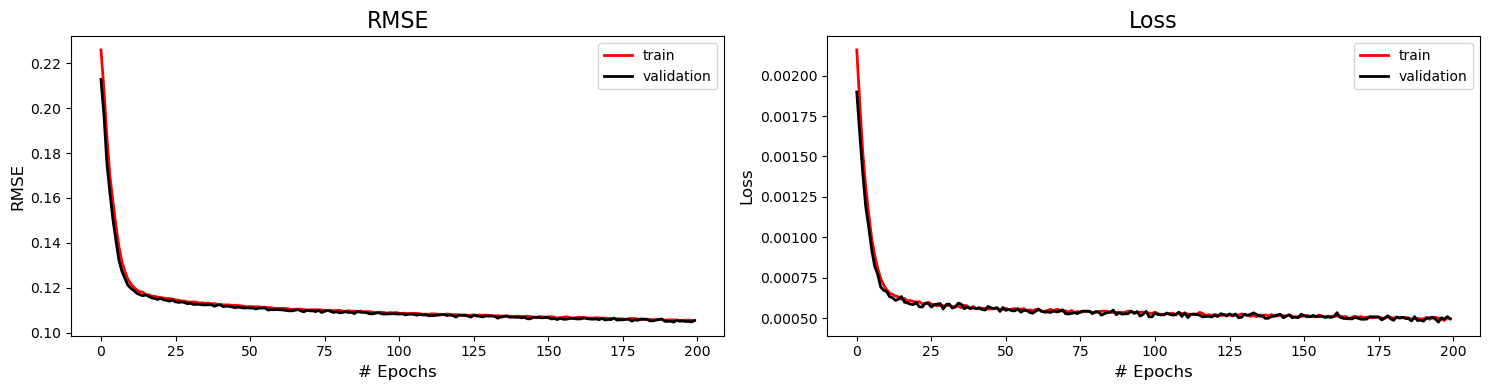

In [20]:
# Plotting training metrics using pre-made function
fig,axs = pu.plot_training_metrics(train_accuracy_history,
                                test_accuracy_history,
                                train_loss_history,
                                test_loss_history
                               )

***

## Step five - Apply trained model

The model is now trained and ready for its denoising capabilities to be tested. 

For the standard network application, the noisy image does not require any data patching nor does it require the active pixel pre-processing required in training. In other words, the noisy image can be fed directly into the network for denoising.

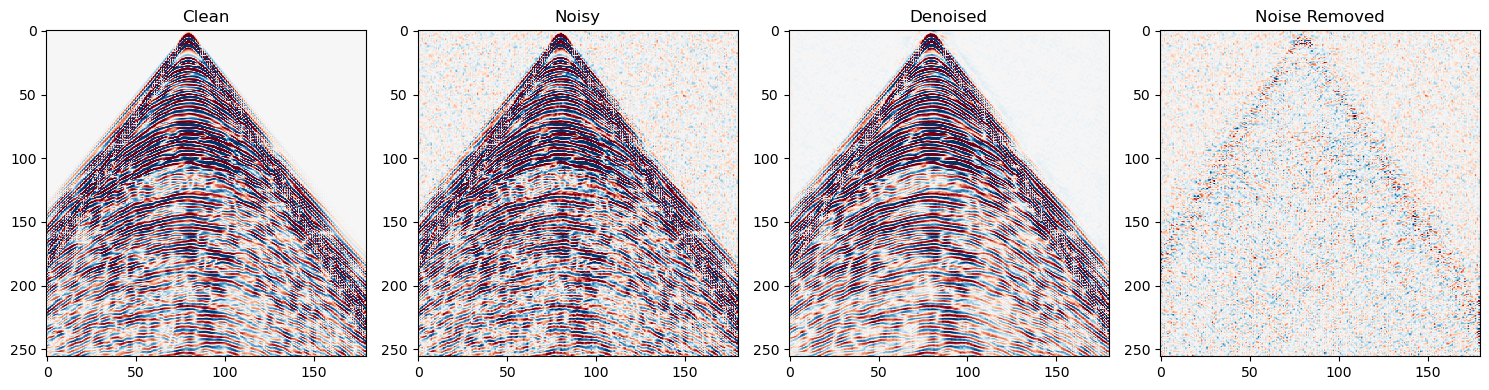

In [21]:
# Convert field dataset to tensor for prediction purposes
test_shot_id = 5
testdata, _ = tu.add_bandlimited_noise(d[test_shot_id], sc=0.05)
torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(testdata,axis=0),axis=0)).float()

# Run test dataset through network
network.eval()
test_prediction = network(torch_testdata.to(device))

# Return to numpy for plotting purposes
test_pred = test_prediction.detach().cpu().numpy().squeeze()

# Use pre-made plotting function to visualise denoising performance
fig,axs = pu.plot_synth_results(d[test_shot_id], testdata, test_pred)